In [1]:
import matplotlib.pylab as plt
import numpy as np
import re
import os
import csv
import pandas as pd
import matplotlib
import copy
import cantera as ct
%matplotlib inline

In [2]:
#ign delay function 

def find_id(time,data):
    m = len(data)
    diff = np.zeros(m)
    diff_l = np.zeros(m)
    diff_r = np.zeros(m)
    a = 0
    for i in range(m):
        if i>1 and i<m-1:
            diff_l[i] = (data[i] - data[i-1])/(time[i]-time[i-1])
            diff_r[i] = (data[i+1] - data[i])/(time[i+1]-time[i])
            diff[i] = (diff_l[i]+diff_r[i])/2
    a = np.max(diff) #slope,m
    b = np.argmax(diff) #location of slope, x1
    
    
    #making of the function (y-y1 = m(x-x1)) 
    y = data[b] #location of y1
    x = time[b]  #location of x1 in terms of the modified time s
    
    #added by Nora 
    print(f'slope (a): {a}, location of slope (b): {b}, y: {y}, x: {x}')
    
    t_id = -y/a+x #ignition delay location
    
    
    #returning the slope approximation function 
    
    lo = x-0.005
    hi = x+0.005
   
    x_0  = np.linspace(lo,hi)
    y_0 = a*(x_0-x)+y
    print(f'in the find_id function, found :{t_id}')
    return diff,t_id,x_0,y_0

get initial ign delays (below)

In [3]:
gas = ct.Solution('/work/westgroup/nora/Code/projects/PFAS/simulations/WPI_flamespeeds/models/RMG/with_franklins_edits/chemkin/copy_chem_annotated.cti')

['CH2F2(1):0, C3H8(2): 1, O2(3): 6, Ar:93', 'CH2F2(1):0.11,C3H8(2):1.1,O2(3):6,Ar:92.13', 'CH2F2(1):0.52,C3H8(2):1,O2(3):6,Ar:92.5', 'CH2F2(1):2,C3H8(2):1.1,O2(3):6,Ar:90.9', 'CH2F2(1):1.99,C3H8(2):0.5,O2(3):3,Ar:94.7']
starting 1292.51 of 0% CH2F2
Initializing reactor network.
Reactor 0: 106 variables.
              0 sensitivity params.
Number of equations: 106
Maximum time step:                0
slope (a): 51.626421463204466, location of slope (b): 662, y: 0.3456749102719177, x: 3.314999999999949
in the find_id function, found :3.3083043023227763
starting 1467.18 of 0% CH2F2
Initializing reactor network.
Reactor 0: 106 variables.
              0 sensitivity params.
Number of equations: 106
Maximum time step:                0
slope (a): 60.20133747517531, location of slope (b): 50, y: 0.42361618022479847, x: 0.25500000000000034
in the find_id function, found :0.2479633427097951
starting 1818.18 of 0% CH2F2
Initializing reactor network.
Reactor 0: 106 variables.
              0 sensit

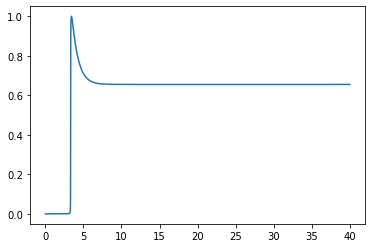

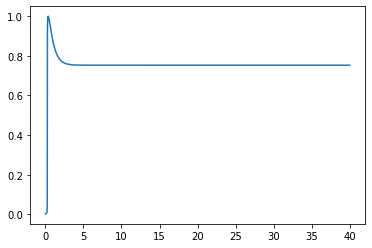

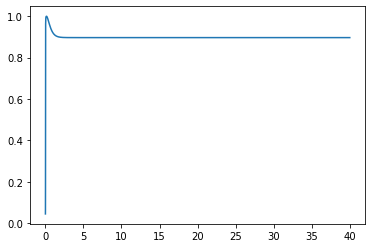

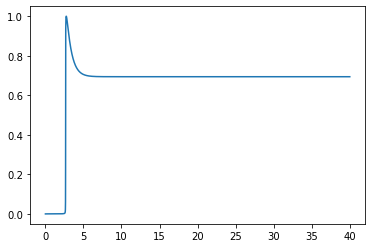

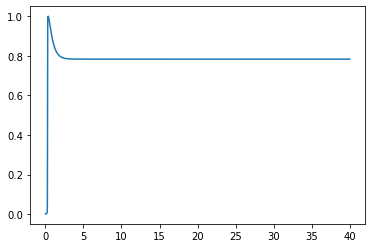

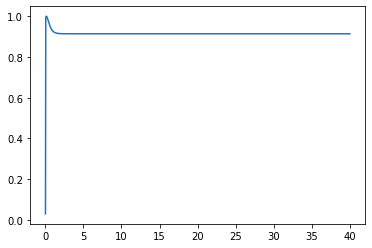

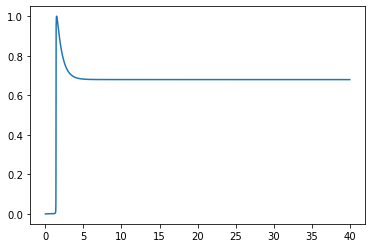

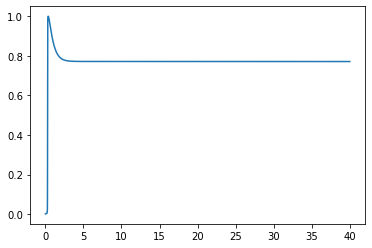

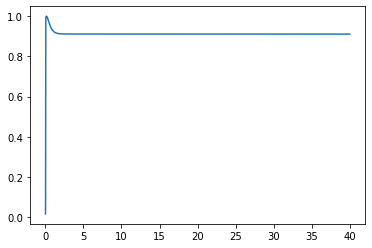

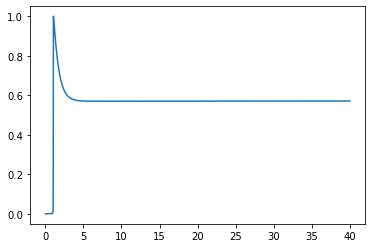

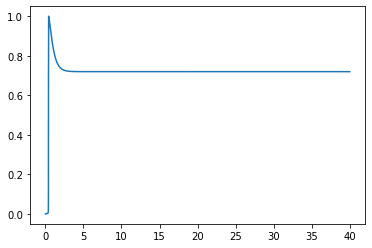

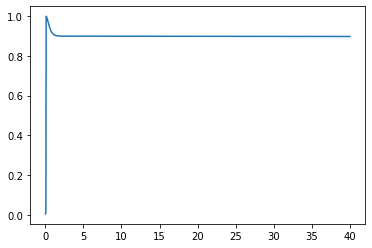

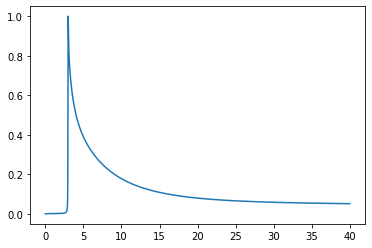

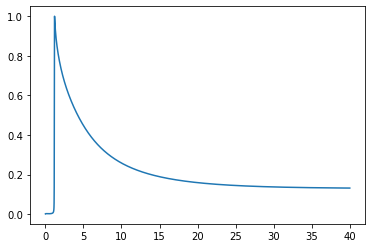

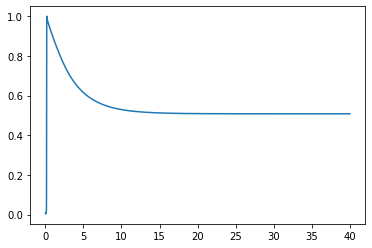

In [3]:
#lets take 3 different temps (before flip flop, in middle, after flip flop)
particular_temps = [1292.51, 1467.18, 1818.18]
columns_ = ['X% CH2F2', f'Temp {particular_temps[0]}', f'Temp {particular_temps[1]}',f'Temp {particular_temps[2]}']


X_list = [0,0.1,0.5,2,4]
concentrations = ['0','0.1', '0.5', '2', '4']
conc_names = ['CH2F2(1):0, C3H8(2): 1, O2(3): 6, Ar:93','CH2F2(1):0.11,C3H8(2):1.1,O2(3):6,Ar:92.13','CH2F2(1):0.52,C3H8(2):1,O2(3):6,Ar:92.5','CH2F2(1):2,C3H8(2):1.1,O2(3):6,Ar:90.9','CH2F2(1):1.99,C3H8(2):0.5,O2(3):3,Ar:94.7']

pressure_dict = {0: 1,  #I'm just assuming this is 1 atm for no CH2F2, there's actually no csv file for it
    0.1:  1.0127232051380075,
    0.5:  1.0158269373681306, 
    2: 1.012855580622881,
    4: 0.9891502432791955}

master_dict={}
data_for_csv = []

for index, x in enumerate(X_list): 
    
    mole_frac_dict = conc_names[index]
    print(conc_names)
    
    t_id_nuig = np.zeros(len(particular_temps))
    for i in range(len(particular_temps)):
        print(f'starting {particular_temps[i]} of {concentrations[index]}% CH2F2')
                        
        gas.TPX = particular_temps[i],pressure_dict[x]*ct.one_atm, mole_frac_dict
        r = ct.Reactor(contents=gas)


        sim = ct.ReactorNet([r])
        sim.verbose = True

        states = ct.SolutionArray(gas, extra=['t'])
        
                
        dt_max = 5e-6
        t_end = (2000 * dt_max)*4

        while sim.time < t_end:
            sim.advance(sim.time + dt_max)
            states.append(r.thermo.state, t=sim.time*1e3)


        diff,t_id,x_0,y_0 = find_id(states.t,states.X[:, gas.species_index('OH(7)')]/np.max(states.X[:, gas.species_index('OH(7)')]))
        t_id_nuig[i] = t_id #id in ms
        
    
        plt.figure()
        plt.plot(states.t,states.X[:, gas.species_index('OH(7)')]/np.max(states.X[:, gas.species_index('OH(7)')]))
#  #save the data 
    data_for_csv.append([x, *t_id_nuig])
    master_dict[x] = t_id_nuig

df = pd.DataFrame(data_for_csv, columns=columns_)
df.to_csv('/work/westgroup/nora/Code/projects/PFAS/simulations/WPI_flamespeeds/sensitivities/RMG/initial_ign_delays/initial_ignition_delays_new_temps.csv',index=False)
  

get ign delays after perturbing each reaction (run with sbatch script)

## Now lets calculate the sensitivities

for 0% CH2F2 in propane

let's calculate the sensitivities and save these to a csv file

In [6]:
#sensitivity 

#initial ignition delays data

# init_id_1292 = full_path + "projects/PFAS/models/C3H8_CH2F2/comparison_of_models/noras_ign_delays/initial_ign_delays/initial_ign_delays_1292.5170068027212"
# init_id_1467 = full_path + "projects/PFAS/models/C3H8_CH2F2/comparison_of_models/noras_ign_delays/initial_ign_delays/initial_ign_delays_1467.1814671814673"
# init_id_1818 = full_path + "projects/PFAS/models/C3H8_CH2F2/comparison_of_models/noras_ign_delays/initial_ign_delays/initial_ign_delays_1818.181818181818"

# df_id_1292 = pd.read_csv(init_id_1292)
# df_id_1467 = pd.read_csv(init_id_1467)
# df_id_1818 = pd.read_csv(init_id_1818)

init_id = "/work/westgroup/nora/Code/projects/PFAS/simulations/WPI_flamespeeds/sensitivities/RMG/initial_ign_delays/initial_ignition_delays_new_temps.csv"

df_id = pd.read_csv(init_id)

In [7]:
df_id

,X% CH2F2,Temp 1292.51,Temp 1467.18,Temp 1818.18
0,0.0,3.308304,0.247963,0.011407
1,0.1,2.650188,0.265286,0.015840
2,0.5,1.387794,0.274663,0.024932
3,2.0,1.028468,0.400719,0.071059
4,4.0,2.942786,1.161062,0.152227


In [13]:
def get_id_sensitivities(x,temp, perturbed_tau, dk): 
    
    """
    sensitivity (S) = ln(tau/tau) / ln(k/k)
    sens = dtau/dk = (tau - tau_i)/(k-k_i)
    take ln of both sides 
    ln(sens) = ln(tau/tau)/ln(1+dk)

    """
    #get initial sensitivities
    if temp == 1818.18:
        tau_i = df_id.loc[df_id['X% CH2F2']==x]['Temp 1818.18'].array[0]
    if temp == 1467.18:
        tau_i = df_id.loc[df_id['X% CH2F2']==x]['Temp 1467.18'].array[0]
    if temp == 1292.51:
        tau_i = df_id.loc[df_id['X% CH2F2']==x]['Temp 1292.51'].array[0]
   
    #now calculate sensitivities
    print(tau_i, perturbed_tau)
    #from franklins modified equation 
    sens = (1/tau_i)*((perturbed_tau-tau_i)/dk)
    return sens, tau_i

In [14]:
X_list = [0,0.1,0.5,2,4]
temps = [1818,1467,1292]
#perturb k
dk = 1e-2

#now go through all the csv files that are in the folder and calculate the sensitivities
list_of_csvs = [file for file in os.listdir('./perturbed_ign_delays') if 'perturbed_ign_delays_' in file]

for file in list_of_csvs: 
    print(file)
    match = re.search('perturbed_ign_delays_([0-9]+\.[0-9]+)_(\S+)', file)
    temp, x = float(match.group(1)), float(match.group(2))
    
    #now read into pd Dataframe and go through each row and calculate the sensitivity
    df_perturbed = pd.read_csv(f'./perturbed_ign_delays/{file}') 
    
    #iterate through all the dataframe rows
    new_csv = []
    columns_ = ["reaction_index", "abs(sens)", "sens", "tau_i", "perturbed_tau"]
    for index, row in df_perturbed.iterrows():
        rxn_index ,perturbed_tau = row["reaction_index"], row[f"Temp {temp}"]
        sens, tau_i = get_id_sensitivities(x,temp, perturbed_tau, dk)
        new_csv.append([rxn_index, abs(sens), sens, tau_i, perturbed_tau])
        
    new_df = pd.DataFrame(new_csv, columns=columns_) 
    new_df.to_csv(f'./perturbed_ign_delays/{temp}_{x}_perturbed_sensitivities', index=False) 
    
        

perturbed_ign_delays_1292.51_0.0
3.3083043023227763 3.2807486786388225
3.3083043023227763 3.308277123245786
3.3083043023227763 3.308202832429905
3.3083043023227763 3.3069559842424834
3.3083043023227763 3.3083008862870624
3.3083043023227763 3.308304357676333
3.3083043023227763 3.308304390233749
3.3083043023227763 3.3083043023227763
3.3083043023227763 3.3083043092411777
3.3083043023227763 3.3083043214331034
3.3083043023227763 3.3083043023227763
3.3083043023227763 3.308304370080798
3.3083043023227763 3.3083047927512634
3.3083043023227763 3.308304361609184
3.3083043023227763 3.3081429287631257
3.3083043023227763 3.307739481303866
3.3083043023227763 3.308262764242412
3.3083043023227763 3.308499117476265
3.3083043023227763 3.307942170549717
3.3083043023227763 3.308488003089595
3.3083043023227763 3.3083163750553903
3.3083043023227763 3.307489377975961
3.3083043023227763 3.308397873013065
3.3083043023227763 3.3083258488309832
3.3083043023227763 3.3083133264737428
3.3083043023227763 3.308320689

Sort the sensitivities

In [15]:
nonsorted_sens_df_1467_0 = pd.read_csv('./perturbed_ign_delays/1467.18_0.0_perturbed_sensitivities')
sorted_sens_df_1467_0 = nonsorted_sens_df_1467_0.sort_values(by=['abs(sens)'], ascending=False)
sorted_sens_df_1467_0.insert(1, "df index", list(range(0, 1095)), True)

sorted_sens_df_1467_0.to_csv('./perturbed_ign_delays/sorted_sens_1467_0.csv')

In [16]:
nonsorted_sens_df_1467_4 = pd.read_csv('./perturbed_ign_delays/1467.18_4.0_perturbed_sensitivities')
sorted_sens_df_1467_4 = nonsorted_sens_df_1467_4.sort_values(by=['abs(sens)'], ascending=False)
sorted_sens_df_1467_4.insert(1, "df index", list(range(0, 1095)), True)

sorted_sens_df_1467_4.to_csv('./perturbed_ign_delays/sorted_sens_1467_4.csv')

In [17]:
nonsorted_sens_df_1292_0 = pd.read_csv('./perturbed_ign_delays/1292.51_0.0_perturbed_sensitivities')
sorted_sens_df_1292_0 = nonsorted_sens_df_1292_0.sort_values(by=['abs(sens)'], ascending=False)
sorted_sens_df_1292_0.insert(1, "df index", list(range(0, 1095)), True)

sorted_sens_df_1292_0.to_csv('./perturbed_ign_delays/sorted_sens_1292_0.csv')

nonsorted_sens_df_1292_4 = pd.read_csv('./perturbed_ign_delays/1292.51_4.0_perturbed_sensitivities')
sorted_sens_df_1292_4 = nonsorted_sens_df_1292_4.sort_values(by=['abs(sens)'], ascending=False)
sorted_sens_df_1292_4.insert(1, "df index", list(range(0, 1095)), True)

sorted_sens_df_1292_4.to_csv('./perturbed_ign_delays/sorted_sens_1292_4.csv')

In [18]:
nonsorted_sens_df_1818_0 = pd.read_csv('./perturbed_ign_delays/1818.18_0.0_perturbed_sensitivities')
sorted_sens_df_1818_0 = nonsorted_sens_df_1818_0.sort_values(by=['abs(sens)'], ascending=False)
sorted_sens_df_1818_0.insert(1, "df index", list(range(0, 1095)), True)

sorted_sens_df_1818_0.to_csv('./perturbed_ign_delays/sorted_sens_1818_0.csv')

nonsorted_sens_df_1818_4 = pd.read_csv('./perturbed_ign_delays/1818.18_4.0_perturbed_sensitivities')
sorted_sens_df_1818_4 = nonsorted_sens_df_1818_4.sort_values(by=['abs(sens)'], ascending=False)
sorted_sens_df_1818_4.insert(1, "df index", list(range(0, 1095)), True)

sorted_sens_df_1818_4.to_csv('./perturbed_ign_delays/sorted_sens_1818_4.csv')

4% / 0% sensitivities 

In [4]:
#full path
full_path = '/work/westgroup/nora/Code/'

#RMG C3H8_CH2F2 model 
yaml = full_path+'projects/PFAS/simulations/WPI_flamespeeds/models/RMG/with_franklins_edits/chemkin/copy_chem0103.cti'
gas=ct.Solution(yaml)

In [20]:
df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1292_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1292_4.csv')

divided_sens = []
for ind in df_0.index:
    reaction_index = df_0['reaction_index'][ind]
    df_0_sens = df_0['abs(sens)'][ind]
    row = df_4.loc[df_4['reaction_index'] == reaction_index]
    df_4_sens = row['abs(sens)']
    divided_sens.append(df_4_sens/df_0_sens)
    
    
df_0.insert(7,'4%_sens / 0%_sens', np.array(divided_sens))
df_0.sort_values('4%_sens / 0%_sens', ascending=False).to_csv('./1292_4_divided_0_sensitivites.csv', index=False)


df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1467_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1467_4.csv')

divided_sens = []
for ind in df_0.index:
    reaction_index = df_0['reaction_index'][ind]
    df_0_sens = df_0['abs(sens)'][ind]
    row = df_4.loc[df_4['reaction_index'] == reaction_index]
    df_4_sens = row['abs(sens)']
    divided_sens.append(df_4_sens/df_0_sens)
    
    
df_0.insert(7,'4%_sens / 0%_sens', np.array(divided_sens))
df_0.sort_values('4%_sens / 0%_sens', ascending=False).to_csv('./1467_4_divided_0_sensitivites.csv', index=False)


df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1818_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1818_4.csv')

divided_sens = []
for ind in df_0.index:
    reaction_index = df_0['reaction_index'][ind]
    df_0_sens = df_0['abs(sens)'][ind]
    row = df_4.loc[df_4['reaction_index'] == reaction_index]
    df_4_sens = row['abs(sens)']
    divided_sens.append(df_4_sens/df_0_sens)
    
    
df_0.insert(7,'4%_sens / 0%_sens', np.array(divided_sens))
df_0.sort_values('4%_sens / 0%_sens', ascending=False).to_csv('./1818_4_divided_0_sensitivites.csv', index=False)


Which reactions are coming up as sensitive? 

In [5]:
#rxn dictionary
rxn_dictionary = {}
for index, rxn in enumerate(gas.reactions()):
    rxn_dictionary[index] = str(rxn)

In [27]:
#1292 4%
df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1292_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1292_4.csv')

reaction_equations=[]
for index, row in df_0.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df_0.insert(4, 'reaction', reaction_equations, True)
df_0.to_csv('./perturbed_ign_delays/sorted_sens_1292_0_with_reactions.csv')

reaction_equations=[]
for index, row in df_4.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df_4.insert(4, 'reaction', reaction_equations, True)
df_4.to_csv('./perturbed_ign_delays/sorted_sens_1292_4_with_reactions.csv')

In [38]:
#1467 4%
df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1467_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1467_4.csv')

reaction_equations=[]
for index, row in df_0.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df_0.insert(4, 'reaction', reaction_equations, True)
df_0.to_csv('./perturbed_ign_delays/sorted_sens_1467_0_with_reactions.csv')

reaction_equations=[]
for index, row in df_4.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df_4.insert(4, 'reaction', reaction_equations, True)
df_4.to_csv('./perturbed_ign_delays/sorted_sens_1467_4_with_reactions.csv')

In [39]:
#1818 4%
df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1818_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1818_4.csv')

reaction_equations=[]
for index, row in df_0.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df_0.insert(4, 'reaction', reaction_equations, True)
df_0.to_csv('./perturbed_ign_delays/sorted_sens_1818_0_with_reactions.csv')

reaction_equations=[]
for index, row in df_4.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df_4.insert(4, 'reaction', reaction_equations, True)
df_4.to_csv('./perturbed_ign_delays/sorted_sens_1818_4_with_reactions.csv')

In [ ]:
#edit the 4/0 sens to have reactions labeled too

In [7]:
#1292 4%
file_name = '1292_4_divided_0_sensitivites_df0'
df = pd.read_csv(f'./{file_name}.csv')

reaction_equations=[]
for index, row in df.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df.insert(2, 'reaction', reaction_equations, True)
df.to_csv(f'{file_name}_with_reactions.csv')

#1467 4%
file_name = '1467_4_divided_0_sensitivites_df0'
df = pd.read_csv(f'./{file_name}.csv')

reaction_equations=[]
for index, row in df.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df.insert(2, 'reaction', reaction_equations, True)
df.to_csv(f'{file_name}_with_reactions.csv')

#1818 4%
file_name = '1818_4_divided_0_sensitivites_df0'
df = pd.read_csv(f'./{file_name}.csv')

reaction_equations=[]
for index, row in df.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
df.insert(2, 'reaction', reaction_equations, True)
df.to_csv(f'{file_name}_with_reactions.csv')


In [10]:
#lets edit the 4/0 sens csvs so that they have the original data of the 4% rather than the 0%

df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1292_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1292_4.csv')

divided_sens = []
for ind in df_0.index:
    reaction_index = df_0['reaction_index'][ind]
    df_0_sens = df_0['abs(sens)'][ind]
    row = df_4.loc[df_4['reaction_index'] == reaction_index]
    df_4_sens = row['abs(sens)']
    divided_sens.append(df_4_sens/df_0_sens)
    
reaction_equations=[]
for index, row in df_4.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
    
df_4.insert(7,'4%_sens / 0%_sens', np.array(divided_sens))
df_4.insert(8, 'reaction', reaction_equations, True)
df_4.sort_values('4%_sens / 0%_sens', ascending=False).to_csv('./1292_4_divided_0_sensitivites_df4_with_reactions.csv', index=False)


df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1467_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1467_4.csv')

divided_sens = []
for ind in df_0.index:
    reaction_index = df_0['reaction_index'][ind]
    df_0_sens = df_0['abs(sens)'][ind]
    row = df_4.loc[df_4['reaction_index'] == reaction_index]
    df_4_sens = row['abs(sens)']
    divided_sens.append(df_4_sens/df_0_sens)
reaction_equations=[]
for index, row in df_4.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])

df_4.insert(7,'4%_sens / 0%_sens', np.array(divided_sens))
df_4.insert(8, 'reaction', reaction_equations, True)
df_4.sort_values('4%_sens / 0%_sens', ascending=False).to_csv('./1467_4_divided_0_sensitivites_df4_with_reactions.csv', index=False)


df_0 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1818_0.csv')
df_4 = pd.read_csv('./perturbed_ign_delays/sorted_sens_1818_4.csv')

divided_sens = []
for ind in df_0.index:
    reaction_index = df_0['reaction_index'][ind]
    df_0_sens = df_0['abs(sens)'][ind]
    row = df_4.loc[df_4['reaction_index'] == reaction_index]
    df_4_sens = row['abs(sens)']
    divided_sens.append(df_4_sens/df_0_sens)
reaction_equations=[]
for index, row in df_4.iterrows(): 
    #find the reaction it is referring to (using dictionary below)
    rxn_index = row["reaction_index"]
    reaction_equations.append(rxn_dictionary[rxn_index])
    
    
df_4.insert(7,'4%_sens / 0%_sens', np.array(divided_sens))
df_4.insert(8, 'reaction', reaction_equations, True)
df_4.sort_values('4%_sens / 0%_sens', ascending=False).to_csv('./1818_4_divided_0_sensitivites_df4_with_reactions.csv', index=False)


In [9]:
rxn_dictionary[286]

'CHF2(24) + O2(3) <=> CHF2OO(25)'